In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# import dask.dataframe as dd
from pathlib import Path
import seaborn as sns
import sys

sys.path.append(str(Path("..").resolve().absolute()))
print(sys.path)

%matplotlib inline

['/home/rayandrew/Projects/anl-cl/prototypes', '/home/rayandrew/.micromamba/envs/acl/lib/python310.zip', '/home/rayandrew/.micromamba/envs/acl/lib/python3.10', '/home/rayandrew/.micromamba/envs/acl/lib/python3.10/lib-dynload', '', '/home/rayandrew/.local/lib/python3.10/site-packages', '/home/rayandrew/.micromamba/envs/acl/lib/python3.10/site-packages', '/home/rayandrew/Projects/anl-cl']


In [2]:
from src.drift_detection.voting import get_offline_voting_drift_detector

In [3]:
from typing import Sequence

DIST_COLUMN="dist_id"

def add_dist_label(data: pd.DataFrame, dist: Sequence[int], start_from=0):
    distributions = np.zeros(len(data), dtype=int)

    print(f"Number of distributions: {len(dist)}")

    distributions[: dist[0]] = start_from
    for i in range(len(dist) - 1):
        distributions[dist[i] : dist[i + 1]] = i + 1 + start_from
    distributions[dist[-1] :] = len(dist) + start_from

    data[DIST_COLUMN] = pd.Series(distributions)
    return data

In [4]:
def plot(stream_window, change, title):
    y = stream_window
    x = [i for i in range(len(y))]

    fig, axs = plt.subplots(2, figsize=(30, 6), sharex=True)

    # Plot the data
    axs[0].scatter(x, y)

    # Add labels and title
    axs[0].set_xlabel("X axis")
    axs[0].set_ylabel("Y axis")
    axs[0].set_title(title)

    # Plot the data
    axs[1].plot(x, y)
    # Add labels and title
    axs[1].set_xlabel("X axis")
    axs[1].set_ylabel("Y axis")
    axs[1].set_title(title)

    fig.tight_layout()

    # Add vertical lines
    index = [i for i in change]
    for i in index:
        if i < len(y):
            axs[0].axvline(x=i, color="red", linestyle="--")
            axs[1].axvline(x=i, color="red", linestyle="--")

    return fig

    # Show the plot
    # plt.savefig(f"{path}")


In [5]:
data = pd.read_parquet("../raw_data/azure/vmcpu.parquet", engine="fastparquet")

In [6]:
# Tolerable spikes
N_SPIKE = 30

def count_iqr(data):
    q75 = data.quantile(0.75)
    q25 = data.quantile(0.25)
    q50 = data.quantile(0.50)
    iqr1 = q75 - q25
    iqr1_1_5 = 1.5*iqr1
    iqr1_3 = 3*iqr1
    lower_inner_fence_1 = q25 - iqr1_1_5
    lower_outer_fence_1 = q25 - iqr1_3
    upper_inner_fence_1 = q75 + iqr1_1_5
    upper_outer_fence_1 = q75 + iqr1_3
    # print("Fences: ", lower_outer_fence_1, lower_inner_fence_1, upper_inner_fence_1, upper_outer_fence_1)
    return lower_outer_fence_1, lower_inner_fence_1, upper_inner_fence_1, upper_outer_fence_1, q25, q75, q50

def dd_slope(data, num_latest):
    lower_outer_fence_1, lower_inner_fence_1, upper_inner_fence_1, upper_outer_fence_1, q25, q75, q50 = count_iqr(data)
    
    dat = [t - s for s, t in zip(data[num_latest:], data[num_latest+1:])]
    spike = len([i for i in dat if i > q25 or i < q75])
    
    if (spike > 2*N_SPIKE):
        # print("====================> Data Drift Detected")
        # print("#Increasing slopes detected      : " + str(spike))
        # print("Mark latency start               : " + str(q25))
        # print("Mark latency end                 : " + str(q75))
        return True
    return False


def discretize_column(df, col, n_bins=4, new_col=None, fr=0, to=100):
    # column = df[col]
    # column = np.clip(column, fr, to)
    if new_col == None:
        new_col = col
    df[new_col] = df[col].apply(np.ceil)
    # print( pd.cut(df[col].clip(fr, to), bins=n_bins, labels=False))
    df = df.copy()
    df[new_col] = pd.cut(df[new_col].clip(fr, to), bins=n_bins, labels=False)
    return df

# test_data = discretize_column(test_data, "p95maxcpu", new_col="p95maxcpu_bucket")

<Axes: >

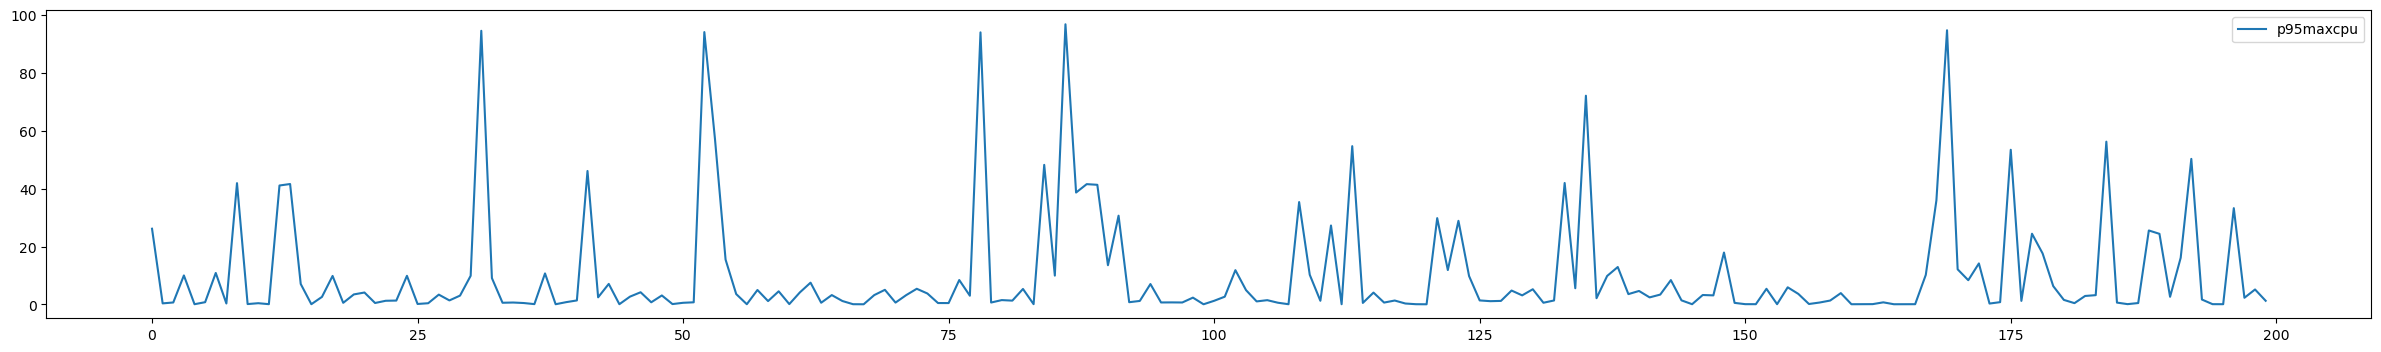

In [7]:
test_data = data.copy().sort_values(by=["vmdeleted"]).reset_index(drop=True).iloc[0:50000]
test_data.iloc[0:200].plot(y="p95maxcpu", figsize=(30, 4))

DRIFT DETECTION KSWIN []
DRIFT DETECTION ADWIN []
DRIFT DETECTION PageHinkley []
DRIFT DETECTION voting [2064]
Number of distributions: 1


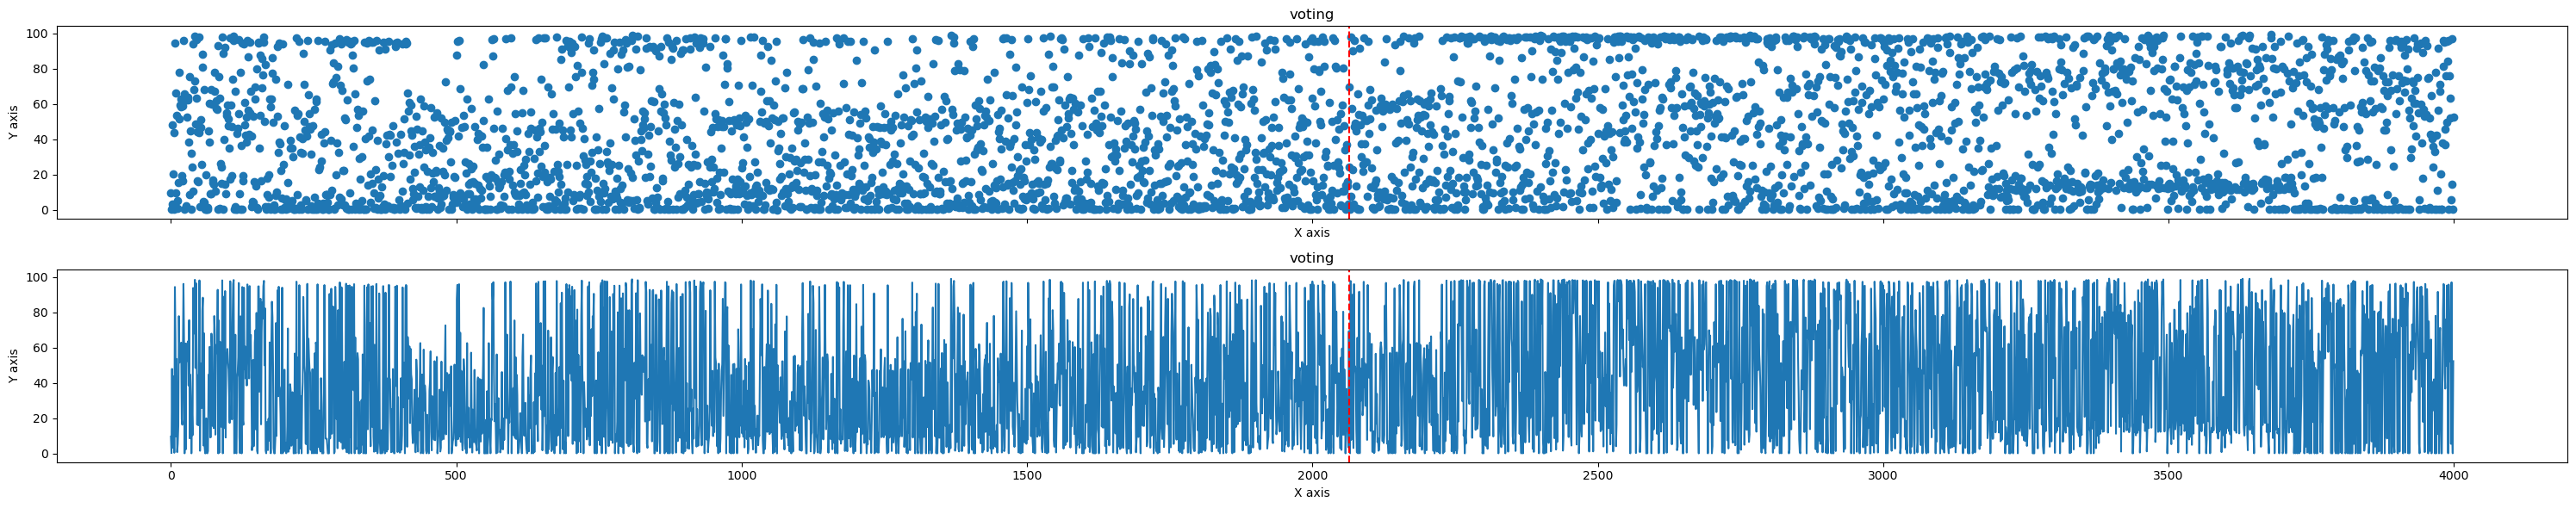

In [21]:
from river import drift
# from sklearn.preprocessing.

# test_data = data.copy().iloc[0:500]
work_df = data.copy().sort_values(by=["vmdeleted"]).reset_index(drop=True)
work_df["day"] = np.floor(work_df["vmdeleted"] / (60 * 60 * 24))
work_df['day'] = work_df['day'].astype('int')

day_group = work_df.groupby(by=["day"])
# test_data = day_group.get_group(0).reset_index(drop=True).iloc[1300:1800]
test_data = day_group.get_group(0).reset_index(drop=True).iloc[1000:5000]
# test_data = discretize_column(test_data, "p95maxcpu", new_col="p95maxcpu")
# test_data.p95maxcpu_bucket = test_data.p95maxcpu_bucket / 3

# print(test_data.p95maxcpu.unique())

dds = [
    # drift.KSWIN(),
    # drift.KSWIN(alpha=0.000001, seed=42, window_size=30, stat_size=10),
    # drift.ADWIN(delta=0.1, clock=1, min_window_length=10, grace_period=5),
    # drift.PageHinkley(min_instances=100, delta=0.0001)
    drift.KSWIN(),
    drift.ADWIN(),
    drift.PageHinkley()
]

mans = [
    dd_slope
]

dists = {}


for i, val in enumerate(test_data.p95maxcpu.values):
    for dd in dds:
        dist = []
        # print(dd)
        _ = dd.update(val)
        if dd.drift_detected:
            dist.append(i)
        dists[str(dd)] = dist


dd = get_offline_voting_drift_detector(window_size=100, threshold=10)
dists["voting"] = dd.predict(test_data.p95maxcpu)

# k=10
# BATCH_SIZE=50
# initial_data = initial_df['p95maxcpu'].iloc[:k+BATCH_SIZE-1]
# for i in range(1, len(test_data)):
#     test_data['p95maxcpu'].iloc[:k+BATCH_SIZE-1]
#     if man(val, i):
#         dist.append(i)
    
# for i, val in enumerate(test_data.p95maxcpu):
#     for man in mans:
#         dist = []
#         if man(val, i):
#             dist.append(i)

for dd, dist in dists.items():
    print("DRIFT DETECTION", dd, dist)
    if len(dist) > 0:
        plot_data = add_dist_label(test_data, dist)
        fig = plot(plot_data.p95maxcpu, dist, dd)
        plt.show(fig)
        plt.close(fig)
        print()
        print()

<Axes: xlabel='x', ylabel='p95maxcpu_bucket'>

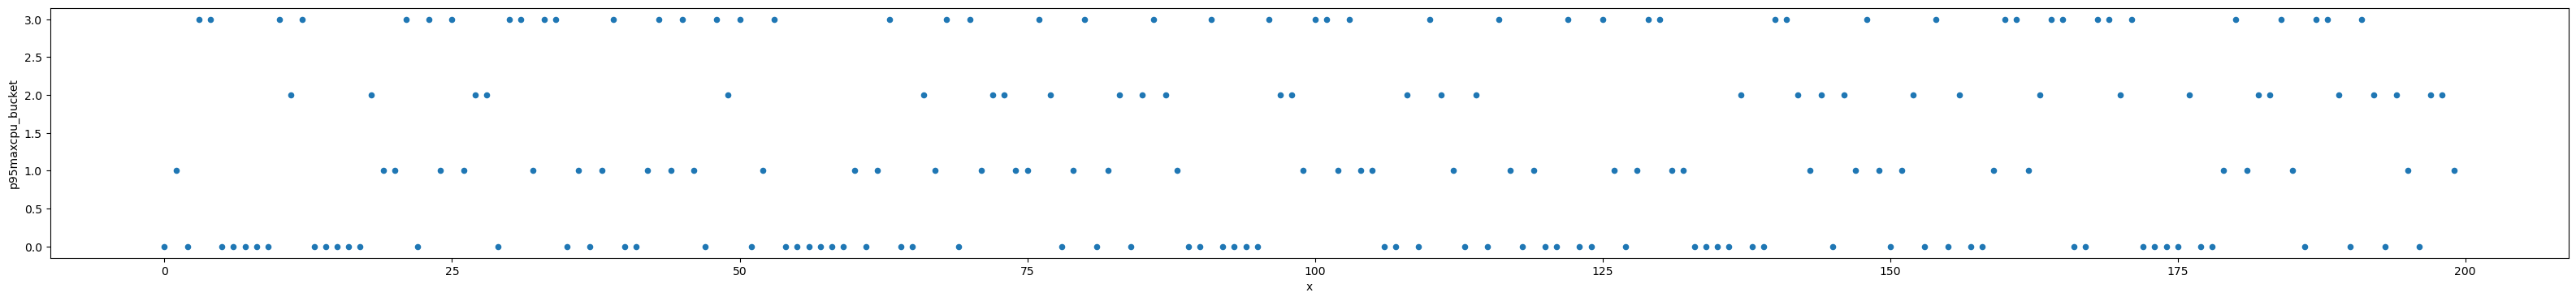

In [9]:
test_data = data.copy().iloc[0:10000]
test_data = discretize_column(test_data, "p95maxcpu", new_col="p95maxcpu_bucket")
test_data["x"] = test_data.index


test_data.iloc[0:200].plot.scatter(x="x", y="p95maxcpu_bucket", figsize=(40, 4))

In [10]:
# k=10
# BATCH_SIZE=50
# test_data['p95maxcpu'].iloc[:k+BATCH_SIZE-1]/test_data['avgcpu'].iloc[:k+BATCH_SIZE-1]

In [11]:

# NON_FEATURE_COLUMNS = [
#     "vmid",
#     "subscriptionid",
#     "deploymentid",
#     "vmcreated",
#     "vmdeleted",
#     "maxcpu",
#     "p95maxcpu",
#     "avgcpu",
#     "vmcategory",
#     "vmcorecountbucket",
#     "vmmemorybucket",
#     "lifetime",
#     "corehour",
# ]
# list(filter(lambda x: x != "p95maxcpu", NON_FEATURE_COLUMNS))

In [12]:
import numpy as np

def f(x,alpha):
    y = np.zeros(x.shape[0])
    z = alpha*np.sin(np.pi*x[:,0]) - x[:,1]
    y[z>=0] = 1
    return y

def get_points(bs,mean_key):
    mean = np.asarray([(mean_key+1)*0.1,(mean_key+1)*0.1])
    points = np.random.normal(loc=mean, scale=0.015, size=(bs,2)) 
    points[points<0] = 0
    points[points>1] = 1
    return points

   
class sine_covcon:
   
    def __init__(self, bs):
        self.batch_size = bs

    def generate(self,t):
       
        x = get_points(self.batch_size,t%7)  
        if t <= 25:
            alpha = 0.8
            y = f(x,alpha).reshape((-1,1))
        elif t>25 and t<=50:
            alpha = 1
            y = f(x,alpha).reshape((-1,1))
        elif t>50 and t<=75:
            alpha = 0.8
            y = 1 - f(x,alpha).reshape((-1,1))
        else:
            alpha = 1
            y = 1 - f(x,alpha).reshape((-1,1))
       
        return np.concatenate([x,y],axis=1)


In [13]:
covcon = sine_covcon(4)

# for 